In [1]:
import torch
from torch import nn
from PIL import Image, ImageDraw
from model import custom_model
from torchvision import transforms
from utils import custom_dataset
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from create_dataset import criar_imagem

In [2]:
IMG_SIZE = 150
N_GRIDS = 5

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

inv_transformer = transforms.Compose([
    transforms.Normalize(mean=(-1., -1., -1), std=(2., 2., 2.)),
    transforms.ToPILImage()
])
def collate_function(batch):
    
    imgs_tensor, bbox_tensor, target_tensor = [], [], []
    
    for annotations, img_path in batch:
        for annotation in annotations:
            img_pil, p_obj, bbox_obj, bbox_cell, target = annotation
            imgs_tensor.append(transformer(img_pil))
            bbox_tensor.append(bbox_obj)
            target_tensor.append(target)
    
    imgs_tensor = torch.stack(imgs_tensor)
    bbox_tensor = torch.tensor(bbox_tensor, dtype=torch.float)
    target_tensor = torch.tensor(target_tensor, dtype=torch.long)

    return imgs_tensor, bbox_tensor, target_tensor

In [4]:
df = pd.read_csv('annotations.csv')
dataset = custom_dataset(df, IMG_SIZE=IMG_SIZE, N_GRIDS=N_GRIDS)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_function)
imgs_tensor, bbox_tensor, target_tensor = next(iter(dataloader))

print (f'{imgs_tensor.shape=}')

model = custom_model(imgs_tensor, 3, IMG_SIZE, N_GRIDS, transformer, inv_transformer)

imgs_tensor.shape=torch.Size([64, 3, 30, 30])


In [5]:
checkpoint = torch.load('checkpoint.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

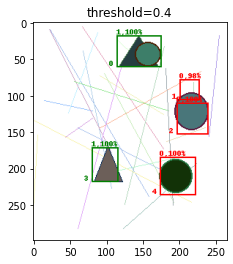

In [136]:
img_original, _ = criar_imagem('', n=5)
img_pil = img_original.copy()

threshold=0.4
deteccoes = model.detect(img_pil, threshold=threshold, device=torch.device('cpu'))

draw = ImageDraw.Draw(img_pil)
for k, (bbox, classe, prob) in enumerate(deteccoes):
    cor = {0: 'red', 1: 'green'}
    draw.rectangle(bbox, fill=None, width=2, outline=cor[classe])
    x0, y0, x1, y1 = bbox
    draw.text((x0, y0-10), f'{str(classe)},{str(round(prob*100))}%', fill=cor[classe])
    draw.text((x0-10, y1-10), f'{str(k)}', fill=cor[classe])

plt.figure(figsize=(10, 4))
plt.title(f'{threshold=}')
plt.imshow(img_pil)
plt.show()

In [115]:
img_original.save('img_pil_teste.jpg')

# Análise das detecções

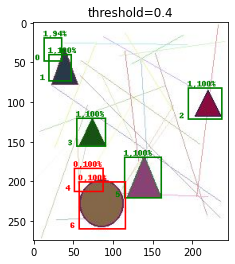

In [161]:
img_pil = Image.open('img_pil_teste.jpg')

threshold=0.4
deteccoes = model.detect(img_pil, threshold=threshold)

draw = ImageDraw.Draw(img_pil)
for k, (bbox, classe, prob) in enumerate(deteccoes):
    cor = {0: 'red', 1: 'green'}
    draw.rectangle(bbox, fill=None, width=2, outline=cor[classe])
    x0, y0, x1, y1 = bbox
    draw.text((x0, y0-10), f'{str(classe)},{str(round(prob*100))}%', fill=cor[classe])
    draw.text((x0-10, y1-10), f'{str(k)}', fill=cor[classe])

plt.figure(figsize=(10, 4))
plt.title(f'{threshold=}')
plt.imshow(img_pil)
plt.show()

In [138]:
def calculate_iou(bbox1, bbox2):
    # Analisa o bbox mais à esquerda
    (bboxe, bboxd) = (bbox1, bbox2) if (bbox1[0] < bbox2[0]) else (bbox2, bbox1)

    x0e, y0e, x1e, y1e = bboxe  # pegas as variáveis da esquerda apenas para facilitar a fórmula
    x0d, y0d, x1d, y1d = bboxd  # o mesmo para as variáveis do bbox da direita.
    
    (y1t, y0b) = (y1e, y0d) if (y0e < y0d) else (y1d, y0e)  # analisa os elementos mais acima top ou mais abaixo bottom

    inter = max(0, (x1e - x0d)) * max(0, (y1t - y0b))  # intercessão
    union = (x1e - x0e)*(y1e - y0e) + (x1d - x0d)*(y1d - y0d) - inter  # união: somatório das duas áreas - intercessão

    return inter / union

In [175]:
img_pil = Image.open('img_pil_teste.jpg')
deteccoes = model.detect(img_pil, threshold=threshold)

# ordenando as detecções primeiro por objeto e depois por probs
# deteccoes = sorted([[bbox, classe, prob] for bbox, classe, prob in deteccoes], key=lambda item: (item[1], item[2]), reverse=True)

for k, (bbox, classe, pred) in enumerate(deteccoes):
    print (f'{k=}, {bbox=}, {classe=}, {pred=}')

ious = []
for k in range(len(deteccoes)):
    for j in range(k+1, len(deteccoes), 1):
        bbox1, classe1, prob1 = deteccoes[k]
        bbox2, classe2, prob2 = deteccoes[j]
        ious.append([k, j, calculate_iou(bbox1, bbox2)if classe1 == classe2 else 0.0, prob1, prob2]) 
        # se as classes são diferentes, então iou é zero logo de cara. também adicionamos as probabilidades para pegar a maior.

ious = [[ind1, ind2, iou, prob1, prob2] for ind1, ind2, iou, prob1, prob2 in ious if iou != 0.0]

indices_excluir = []
for ind1, ind2, iou, prob1, prob2 in ious:
    menor_ind = ind1 if ind1 < ind2 else ind2
    indices_excluir.append(menor_ind)

novas_deteccoes = [deteccao for k, deteccao in enumerate(deteccoes) if k not in indices_excluir]

print ('============================ novas detecções ============================')
for k, (bbox, classe, pred) in enumerate(novas_deteccoes):
    print (f'{k=}, {bbox=}, {classe=}, {pred=}')

k=0, bbox=[13.769165754318237, 19.286787581443786, 36.99333128929138, 49.21675965785981], classe=1, pred=0.9403717
k=1, bbox=[19.444006383419037, 40.0169095993042, 48.14014030694962, 74.16240322589874], classe=1, pred=0.99977046
k=2, bbox=[194.08812868595123, 82.17104884386062, 237.25823414325714, 122.63288220167159], classe=1, pred=0.99999976
k=3, bbox=[54.621019756793984, 120.11418061256408, 91.90764988660813, 156.43284173011781], classe=1, pred=0.9995258
k=4, bbox=[51.87344319820404, 183.05767521858215, 88.90166301727295, 213.27177920341492], classe=0, pred=0.9981888
k=5, bbox=[114.3340933084488, 169.40202550888063, 161.87744386196138, 221.89488277435302], classe=1, pred=0.9999902
k=6, bbox=[57.35344970226288, 200.38167828321457, 116.32919404506683, 260.37285069227215], classe=0, pred=0.99999976
============================ novas detecções ============================
k=0, bbox=[19.444006383419037, 40.0169095993042, 48.14014030694962, 74.16240322589874], classe=1, pred=0.99977046
k=

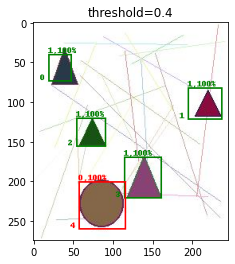

In [176]:
img_pil = Image.open('img_pil_teste.jpg')

threshold=0.4

draw = ImageDraw.Draw(img_pil)
for k, (bbox, classe, prob) in enumerate(novas_deteccoes):
    cor = {0: 'red', 1: 'green'}
    draw.rectangle(bbox, fill=None, width=2, outline=cor[classe])
    x0, y0, x1, y1 = bbox
    draw.text((x0, y0-10), f'{str(classe)},{str(round(prob*100))}%', fill=cor[classe])
    draw.text((x0-10, y1-10), f'{str(k)}', fill=cor[classe])

plt.figure(figsize=(10, 4))
plt.title(f'{threshold=}')
plt.imshow(img_pil)
plt.show()